In [1]:
# %matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import skimage.external.tifffile as tiff

from common import Statistics, dataset_source
from resources.conv_learner import *
from resources.plots import *
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
path = "datasets/Hirano3D/"
# data_path = Path(PATH)

In [28]:
NUM_CLASSES = 4
bs = 64
sz = [4,512,512]

In [5]:
_clss = {'NM17-002': 0,
         'Ctrl-AK': 0,
         'GUK1-D': 1, 
         'GUK1-R': 1,
         'MFN2-1': 2,
         'VCP-1': 3}

#### CV generation via sklearn, Multilabel implementation by trent-b, or FastAi

Both libraries seem to be completely useless... can just use native fastai function: get_cv_idxs().<br>
However, get_cv_idxs() does NOT shuffle...!

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

def get_label_stratified_CV_idxs2(csv_path):
    
    _all_labels = pd.read_csv(csv_path)
    arr = _all_labels.values

    X = arr[:,0]
    y = arr[:,1:]
    
    ### sklearn.model_selection.StratifiedKFold
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
    
    for train_index, val_index in sss.split(X, y):
        trn_idxs = train_index
        val_idxs = val_index
    
    print(f"""Train label-distribution:\n"""
          f"""{pd.Series(arr[:,1][trn_idxs]).value_counts()}""")
    print(f"""Val label-distribution:\n"""
          f"""{pd.Series(arr[:,1][val_idxs]).value_counts()}""")
    
    return trn_idxs, val_idxs


from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

def get_label_stratified_CV_idxs(csv_path):
    
    _all_labels = pd.read_csv(csv_path)
#     _all_labels['fake'] = pd.Series(np.zeros(len(_all_labels), dtype=int)) #need fake secondary-label column
    _all_labels['fake'] = _all_labels.Targets.copy() #need fake secondary-label column
    arr = _all_labels.values

    X = arr[:,0]
    y = arr[:,1:]
    
    ### Iterative stratification library: https://github.com/trent-b/iterative-stratification
    msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    
    for train_index, val_index in msss.split(X, y):
        trn_idxs = train_index
        val_idxs = val_index
    
    print(f"""Train label-distribution:\n"""
          f"""{pd.Series(arr[:,1][trn_idxs]).value_counts()}""")
    print(f"""Val label-distribution:\n"""
          f"""{pd.Series(arr[:,1][val_idxs]).value_counts()}""")
    
    return trn_idxs, val_idxs

In [6]:
### used atm...
csv_path = path + 'multi_folder_Hirano3D_v1.csv'
trn_idxs, val_idxs = get_label_stratified_CV_idxs2(csv_path)

Train label-distribution:
0    216
1    163
2    161
3    124
dtype: int64
Val label-distribution:
0    54
1    41
2    40
3    31
dtype: int64


In [ ]:
# csv_path = path + 'multi_folder_Hirano3D_02.csv'
# trn_idxs, val_idxs = get_label_stratified_CV_idxs(csv_path)

In [146]:
# setting up a list of a random 20% of images in train as the validation set

# lbl_csv = path + 'multi_folder_Hirano3D_02.csv'
# n = len(list(open(lbl_csv))) -1
# val_idxs = get_cv_idxs(n, val_pct=0.2)


# # Count labels
# # _all_labels = pd.read_csv(PATH + 'multi_folder_Hirano3D_02.csv')
# # print(_all_labels.Targets.value_counts())

# _arr = _all_labels.values
# _val_labels = pd.DataFrame(_arr[val_idxs], columns=['Id','Targets'])
# print(_val_labels.Targets.value_counts())

0    64
1    43
2    39
3    32
Name: Targets, dtype: int64


### Define Dataloader:

In [29]:
def get_data(path, lbl_csv, val_idxs, sz, bs, aug_tfms):

    tfms = tfms_with_IntNorm(sz, aug_tfms=aug_tfms, crop_type=CropType.CENTER)
    data = ImageClassifierData.from_csv(PATH, 'data', lbl_csv, 
                                        val_idxs = val_idxs,
                                        test_name='data/16bit_Hirano3D_MaxP_GRFB_test_512', 
                                        tfms=tfms, bs=bs, suffix = '.tif', 
                                        balance=True)
    return data

In [30]:
PATH = "datasets/Hirano3D/"
# data_path = Path(PATH)

In [31]:
# define augmentations
augs = [RandomDihedral()]

# csv:
lbl_csv = path + '16bit_multi_folder_Hirano3D_v1.csv'

# initialize data object
data = get_data(PATH, lbl_csv, val_idxs, sz, bs, aug_tfms = augs)

Internal Normalization
val_crop is: 2
Calculating weights...
one-hot encoding single-labels...
Weights calculated successfully!
Using WeightedRandomSampler


### inpsect data_loaders

In [ ]:
x, y = next(iter(data.trn_dl))
# x_test, y_test = next(iter(data.test_dl))

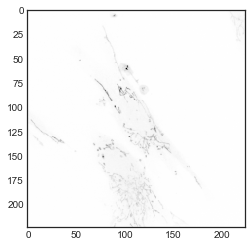

In [60]:
plt.imshow(to_np(x)[5][2])

In [ ]:
# loading epoch for manual inspection...

In [ ]:
def load_epoch(dl = data.trn_dl):
    
    batch = iter(dl)

    xs = []
    ys = []

#     for b in range(0,len(dl)):
    for b in range(0,10):

        x_, y_ = next(batch)
        x_np, y_np = to_np(x_), to_np(y_)
        xs.append(x_np)
        ys.append(y_np)

    return np.vstack(xs), np.concatenate(ys)


### inpsecting loaded images and labels

In [41]:
def to_label(y):
    ind = [i for i, p in enumerate(y) if y[i]==1]
    return(ind)

1


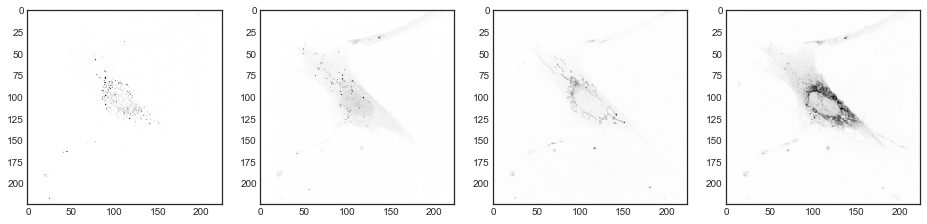

In [62]:
# inspect train images
plt.style.use('seaborn-white')

idx = 2

im = to_np(x)[idx]

lbl = to_np(y)[idx]
# lbl = to_label(to_np(y)[idx])
print(lbl)

fig, ax = plt.subplots(1,4, figsize=(16,10))
for i, ax in enumerate(ax.flat):
    ax.imshow(im[i])

In [ ]:
# inspect test images
plt.style.use('seaborn-white')

idx = 3

im = to_np(x_test)[idx]

# lbl = to_label(to_np(y)[idx])
# print(lbl)

fig, ax = plt.subplots(1,4, figsize=(16,10))
for i, ax in enumerate(ax.flat):
    ax.imshow(im[i])

# training

In [64]:
torch.cuda.is_available()

True

In [32]:
# base-model

arch = resnet18_c
# arch = resnet50
learn = ConvLearner.pretrained(arch, data, ps=0, opt_fn=optim.Adam, pretrained=False)

In [33]:
# additional parameters

wd=1e-5 # weight-decay/L2 regularization 
# learn.metrics = [accuracy_thresh(0.5),f1_macro]

In [71]:
learn.unfreeze()

In [72]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 4, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', True),
                           ('nb_params', 12544)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', True),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 5

In [ ]:
learn.lr_find()

In [ ]:
learn.sched.plot()

In [ ]:
# training loops:

In [75]:
%time learn.fit(1e-4, 8, cycle_len=1, wds=wd, use_wd_sched=True)

EPOCH 0 ---------------------------------------- STEP 10                                                                                                                                                             
epoch      trn_loss   val_loss   accuracy   
    0      1.101626   1.632084   0.313253  
EPOCH 1 ---------------------------------------- STEP 11                                                                                                                                                             
    1      1.052936   1.104769   0.487952  
EPOCH 2 ---------------------------------------- STEP 12                                                                                                                                                             
    2      1.050745   1.126477   0.506024  
EPOCH 3 ---------------------------------------- STEP 13                                                                                                                             

[array([1.20886]), 0.4578313317643591]

In [76]:
%time learn.fit(1e-5, 4, cycle_len=8, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85))

EPOCH 0 ---------------------------------------- STEP 18                                                                                                                                                             
epoch      trn_loss   val_loss   accuracy   
    0      1.000245   1.084029   0.53012   
EPOCH 1 ---------------------------------------- STEP 19                                                                                                                                                             
    1      0.977935   1.085045   0.548193  
EPOCH 2 ---------------------------------------- STEP 20                                                                                                                                                             
    2      0.985891   1.078378   0.560241  
EPOCH 3 ---------------------------------------- STEP 21                                                                                                                             

[array([1.05921]), 0.5602409667279347]

In [79]:
%time learn.fit(1e-4, 2, cycle_len=16, cycle_mult=2, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85))

EPOCH 0 ---------------------------------------- STEP 98                                                                                                                                                             
epoch      trn_loss   val_loss   accuracy   
    0      0.692218   1.4571     0.451807  
EPOCH 1 ---------------------------------------- STEP 99                                                                                                                                                             
    1      0.680981   1.083467   0.53012   
EPOCH 2 ---------------------------------------- STEP 100                                                                                                                                                            
    2      0.696728   0.784001   0.668675  
EPOCH 3 ---------------------------------------- STEP 101                                                                                                                            

[array([0.76079]), 0.6626506088727928]

In [83]:
%time learn.fit(2e-5, 1, cycle_len=8, cycle_mult=2, wds=wd, use_wd_sched=True)

EPOCH 0 ---------------------------------------- STEP 288                                                                                                                                                            
epoch      trn_loss   val_loss   accuracy   
    0      0.239992   0.886651   0.704819  
EPOCH 1 ---------------------------------------- STEP 289                                                                                                                                                            
    1      0.250756   0.884499   0.710843  
EPOCH 2 ---------------------------------------- STEP 290                                                                                                                                                            
    2      0.254156   0.907271   0.692771  
EPOCH 3 ---------------------------------------- STEP 291                                                                                                                            

[array([0.92409]), 0.7048192828534597]

In [ ]:
lr = (5e-4, 1e-3, 5e-3)

In [90]:
sz = [4,516, 516]
learn.set_data(get_data(PATH, lbl_csv, val_idxs, sz, bs, aug_tfms = augs))

Calculating weights...
one-hot encoding single-labels...
Weights calculated successfully!
Using WeightedRandomSampler


In [93]:
%time learn.fit(1e-3, 1, cycle_len=8, cycle_mult=2, wds=wd, use_wd_sched=True)

EPOCH 0 ---------------------------------------- STEP 312                                                                                                                                                            
epoch      trn_loss   val_loss   accuracy   
    0      0.813161   0.970977   0.638554  
EPOCH 1 ---------------------------------------- STEP 313                                                                                                                                                            
    1      0.736871   0.858923   0.644578  
EPOCH 2 ---------------------------------------- STEP 314                                                                                                                                                            
    2      0.707892   0.792873   0.644578  
EPOCH 3 ---------------------------------------- STEP 315                                                                                                                            

[array([0.74072]), 0.6807228851031109]

In [100]:
%time learn.fit(1e-3, 2, cycle_len=8, wds=wd, use_wd_sched=True)

EPOCH 0 ---------------------------------------- STEP 376                                                                                                                                                            
epoch      trn_loss   val_loss   accuracy   
    0      0.389027   0.80013    0.692771  
EPOCH 1 ---------------------------------------- STEP 377                                                                                                                                                            
    1      0.37939    0.807519   0.698795  
EPOCH 2 ---------------------------------------- STEP 378                                                                                                                                                            
    2      0.358142   0.822127   0.698795  
EPOCH 3 ---------------------------------------- STEP 379                                                                                                                            

[array([0.8419]), 0.6987951871860458]

In [97]:
learn.save('Hirano3D_v1_ResNet18_512_72')

In [34]:
learn.load('Hirano3D_v1_ResNet18_512_72')

In [35]:
learn.warm_up(1e-10)

EPOCH 0 ---------------------------------------- STEP 2                                                                                                                                                              
epoch      trn_loss   val_loss   accuracy   
    0      2.438232   3.509747   0.349398  

appending existing log-files...
log-files saved to: datasets/Hirano3D/


[array([3.50975]), 0.3493975935930229]

## test-predictions

In [141]:
log_preds, y = learn.TTA(n_aug=8)
preds = np.argmax(log_preds, axis=1)
print(preds)

In [145]:
log_preds, y =  learn.TTA()

[[30  2  8  4]
 [ 2 31  1  1]
 [10  1 32  3]
 [10  0  5 26]]


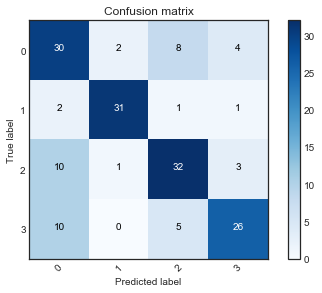

In [146]:
# Plot confusion matrix 
plt.style.use('seaborn-white')
log_preds_mean = np.mean(log_preds, axis=0)
preds = np.argmax(log_preds_mean, axis=1)
cm = confusion_matrix(preds,y)
plot_confusion_matrix(cm, data.classes)

In [14]:
preds = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,2,2,2,2,2,2,2,3,3,3,3,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,3,0,0,0,0,0,0,0,0,0,0,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3]
y = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3]
names = ['WT', 'GUK1','MFN2','VCP']

In [15]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print(accuracy_score(preds, y))

print(classification_report(preds, y, target_names=names))

0.7168674698795181
             precision    recall  f1-score   support

         WT       0.68      0.58      0.62        52
       GUK1       0.89      0.91      0.90        34
       MFN2       0.70      0.70      0.70        46
        VCP       0.63      0.76      0.69        34

avg / total       0.72      0.72      0.71       166



In [134]:
log_preds, y =  learn.TTA(is_test=True)
log_preds_mean = np.mean(log_preds, axis=0)
preds = np.argmax(log_preds_mean, axis=1)
print(preds)

array([0, 3, 0, 0, 0, 2, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0,
       2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 3, 0, 0, 2, 0], dtype=int64)

In [104]:
# function to be called by register_forward_hook

def get_embeddings(layer_name):
    def register_hook(layer_name):
        def get_embedding(layer, inp, outp):
            tmp = inp[0]
            embedding.append(tmp)

        hook = layer.register_forward_hook(get_embedding) 
        
        for i in ['trn', 'val', 'test']:
            embedding = []
            preds, y = learn.predict_with_targs(i)
            
            # populating dict, consiting of [0]: preds, [1]: y, [2]: activations[layer]
            embeddings[i] = [preds, y, np.vstack(to_np(embedding))]
            
        hook.remove()
        
    embeddings = {}    
    layer = learn.models.model._modules.get(layer_name)
    register_hook(layer)
    
    return embeddings

In [105]:
embeddings = get_embeddings('14')

In [106]:
# unpacking embeddings

embs_trn = embeddings['trn'][2]
y_trn = embeddings['trn'][1]

embs_val = embeddings['val'][2]
y_val = embeddings['val'][1]

embs_test = embeddings['test'][2]
y_test = embeddings['test'][1]

print(embs_trn.shape)
print(embs_val.shape)
print(embs_test.shape)

print(y_trn.shape)
print(y_val.shape)
print(y_test.shape)


(664, 512)
(166, 512)
(60, 512)
(664,)
(166,)
(60,)


In [107]:
import umap

In [108]:
UMAP_trn_embedding = umap.UMAP(n_neighbors=10,
                      min_dist=0.3,
                      metric='correlation').fit(embs_trn)

UMAP_trn = UMAP_trn_embedding.embedding_
UMAP_val = UMAP_trn_embedding.transform(embs_val)
UMAP_test = UMAP_trn_embedding.transform(embs_test)

In [130]:
# data.test_ds.fnames

In [131]:
y_test = np.zeros(60)
y_test[:30] = y_test[:30] +1 
y_test

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

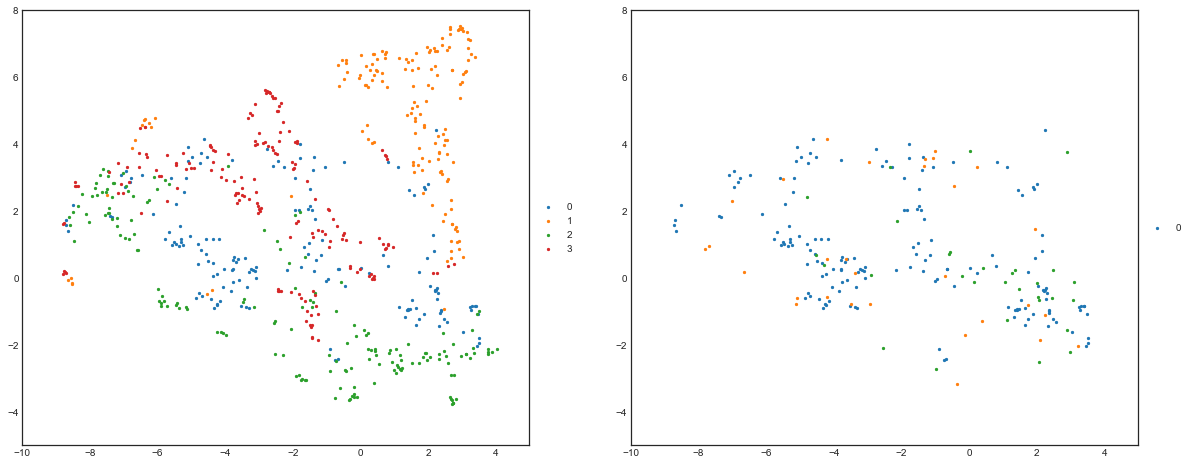

In [132]:
# plotting PCA vs TSNE results

fig, axarr = plt.subplots(1, 2, figsize=(20, 8))

compA = 0
compB = 1

for i in range(4):
    trn_UMAP_cls = UMAP_trn[y_trn == i]

    axarr[0].scatter(trn_UMAP_cls[:,compA], trn_UMAP_cls[:,compB], label = data.classes[i], s = 5)
    axarr[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    if i == 0:
        axarr[1].scatter(trn_UMAP_cls[:,compA], trn_UMAP_cls[:,compB], label = data.classes[i], s = 5)

    axarr[0].set_xlim(-10,5)
    axarr[0].set_ylim(-5,8)
    
for i in [0,1]:
    test_UMAP_cls = UMAP_test[y_test == i]
    
    axarr[1].scatter(test_UMAP_cls[:,compA], test_UMAP_cls[:,compB], s = 5)
    axarr[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axarr[1].set_xlim(-10,5)
    axarr[1].set_ylim(-5,8)


In [ ]:
def opt_th(preds, targs, start=0.2, end=0.6, step=0.05):
    ths = np.arange(start,end,step)
    res = [f1_macro(preds, targs, thresh=th, kind='macro') for th in ths]
    idx = np.argmax(res)
    return ths[idx], res

In [ ]:
# get train predictions

preds_trn, targs_trn =  learn.predict_with_targs('trn')

preds_trn_torch = torch.from_numpy(preds_trn)
targs_trn_torch = torch.from_numpy(targs_trn)

opt_th(preds_trn_torch, targs_trn_torch)

In [ ]:
print(preds_val_torch[0])
print(preds_trn_torch[0])

In [ ]:
# get val predictions

preds_val, targs_val =  learn.predict_with_targs('val')

preds_val_torch = torch.from_numpy(preds_val)
targs_val_torch = torch.from_numpy(targs_val)

opt_th(preds_val_torch, targs_val_torch)

In [ ]:
# get test predictions

preds_test, targs_test =  learn.predict_with_targs('test')

In [ ]:
targs_test[:50]

In [ ]:
def load_epoch(dl = data.trn_dl):
    
    batch = iter(dl)

    xs = []
    ys = []

#     for b in range(0,len(dl)):
    for b in range(0,10):

        x_, y_ = next(batch)
        x_np, y_np = to_np(x_), to_np(y_)
        xs.append(x_np)
        ys.append(y_np)

    return np.vstack(xs), np.concatenate(ys)

In [ ]:
data.test_dl.sampler

In [ ]:
test_names = data.test_ds.fnames
test_names[:10]

In [ ]:
def create_submission(preds_file, output_name, th = 0.3, TTA=False):
    
    # creating submission file
    
    if TTA:
        preds = preds_file.mean(axis=0)
        print('TTA:',preds.shape)
    else: preds = preds_file
    
    clss = np.arange(0, len(data.classes)) # get class indeces
    res = np.array([' '.join(np.char.mod('%d', clss[np.where(p > th)])) for p in preds]) # generating output

    # ensure that there are no empty cells: in case no value > thresh, fill in with argmax()
    for i in range(res.shape[0]):
        if res[i] == '':
            res[i] = preds[i].argmax()

    # getting image Ids
    fnames = np.array([os.path.basename(im).split('.')[0] for im in data.test_ds.fnames])

    # creating submission file
    sub_df = pd.DataFrame(res, index=fnames, columns=['Predicted'])
    sub_df.to_csv(output_name, index_label='Id')

In [ ]:
submission_name = PATH + 'submissions/Res18_pre_0.42_t-03.csv'

create_submission(log_preds, submission_name, th=0.3, TTA=True)

## other stuff

In [ ]:
# List of label identities:

cell_location_label = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }

In [ ]:
# from sklearn.metrics import f1_score

# thresholds = np.linspace(0, 1, 1000)
# score = 0.0
# test_threshold=0.5*np.ones(28)
# best_threshold=np.zeros(28)
# best_val = np.zeros(28)
# for i in range(28):
#     for threshold in thresholds:
#         test_threshold[i] = threshold
#         max_val = np.max(preds_y)
#         val_predict = (preds_y > test_threshold)
#         score = f1_score(valid_y > 0.5, val_predict, average='macro')
#         if score > best_val[i]:
#             best_threshold[i] = threshold
#             best_val[i] = score
#     print("Threshold[%d] %0.6f, F1: %0.6f" % (i,best_threshold[i],best_val[i]))
#     test_threshold[i] = best_threshold[i]
# print("Best threshold: ")
# print(best_threshold)
# print("Best f1:")
# print(best_val)